In [1]:
from qiskit import QuantumRegister, AncillaRegister, QuantumCircuit
from qiskit.circuit.library import MCXGate
from walsh import *
from sequential import *
from primitives import *
from qiskit.tools.visualization import *
import qiskit.quantum_info as qi
import matplotlib.pyplot as plt

## Walsh

In [20]:
def walsh_coeff_non_unitary(j,f,N,d):
    """j-th Walsh coefficient of the N-th Walsh series of f
    Parameters
    ----------
    j : int
        Order of the Walsh coefficient
    f : function
        Function of one variable
    N : int
        Integer representing the number of points on which is computed the Walsh coefficient
    d : function
        Function of one variable
    Returns
    -------
    float
    """
    k = np.array(range(N))/N
    a = 0
    dmax = get_dmax(d,N)
    for i in range(N):
        a += f(k[i],d,dmax) * walsh(j,k[i])/N
    return a

In [22]:
def walsh_informations_non_unitary(n,list_operator_to_implement,f,d,gray_code=True):
    """Returns a dictionnary whose keys are the order of Walsh operators to implement and the
    values are the associated coefficients
    Parameters
    ----------
    n : int
        Number of qubit encoding the position
    list_operator_to_implement : int list
        List of orders of the Walsh operators to implement
    f : function
        Function of one variable
    gray_code : bool
        Set to True if to get a gray code ordering of the orders of the Walsh operators
    d : function
        Function of one variable
    Returns
    -------
    dict
    """
    walsh_dict = {}
    n_operator_to_implement = len(list_operator_to_implement)
    if gray_code:
        gray_list = generate_gray_code(n)
        for i in gray_list:
            if i in list_operator_to_implement:
                walsh_dict[i] = walsh_coeff_non_unitary(i,f,n_operator_to_implement,d)
    else:          
        for i in range(n_operator_to_implement):
            walsh_dict[list_operator_to_implement[i]] = walsh_coeff_non_unitary(list_operator_to_implement[i],f,n_operator_to_implement,d)
    return walsh_dict

In [69]:
def walsh_circuit_non_unitary(n,n_ancilla_qsp,f,walsh_info,gray_code=True):
    """Generates the quantum circuit implementing the Walsh decomposition of function f with the Walsh operators
        whose orders are contain in walsh_info
    Parameters
    ----------
    n : int
        Number of qubit encoding the position
    n_ancilla_qsp : int
        Number of ancilla qubits used to control the rotations gates
    f : function
        Function of one variable
    walsh_info : dict
        Output of function walsh_informations_non_unitary, it is a dictionnary whose keys are the order of Walsh functions to implement and the
        values are the associated coefficients
    gray_code : bool
        Set to True if to get a gray code ordering of the orders of the Walsh operators
    Returns
    -------
    qiskit.circuit.quantumcircuit.QuantumCircuit
    """
    q = QuantumRegister(n,name='q')
    a_qsp = AncillaRegister(n_ancilla_qsp+1,name='a_qsp')
    qc = QuantumCircuit(q,a_qsp)
    
    q_qubits = qc.qubits[:n]
    a_qsp_qubits = qc.qubits[n:]
    
    walsh_operators_list = []
    walsh_operators_dagger_list = []
    order_list = list(walsh_info.keys())
    for order in order_list:
        if gray_code:
            walsh_operators_dagger_list.append(walsh_operator(n,order,-walsh_info[order],cnots=False))
            walsh_operators_list.append(walsh_operator(n,order,walsh_info[order],cnots=False))
        else:
            walsh_operators_dagger_list.append(walsh_operator(n,order,-walsh_info[order]))
            walsh_operators_list.append(walsh_operator(n,order,walsh_info[order]))
    qsp_control_index = 0
    for index,operator in enumerate(walsh_operators_list):
        if gray_code:
            # avoid putting the useless cnots
            rotation_index = first_one_bit(int_to_binary(order_list[index],n,reverse=False))
            if index == 0:
                cnots_index = other_one_bits(int_to_binary(order_list[index],n,reverse=False))
                for j in cnots_index:
                    qc.cx(q[j],q[rotation_index])
                qc.append(walsh_operators_dagger_list[index].control(1),[a_qsp_qubits[qsp_control_index]]+q_qubits)
                qc.append(operator.control(1,ctrl_state='0'),[a_qsp_qubits[qsp_control_index]]+q_qubits)
            elif index > 0:
                previous_cnots_index = other_one_bits(int_to_binary(order_list[index-1],n,reverse=False))
                current_cnots_index = other_one_bits(int_to_binary(order_list[index],n,reverse=False))
                if len(previous_cnots_index) > len(current_cnots_index):
                    cnots_index = list(set(previous_cnots_index)-set(current_cnots_index))
                else:
                    cnots_index = list(set(current_cnots_index)-set(previous_cnots_index))
                for j in cnots_index:
                    qc.cx(q[j],q[rotation_index])
                qc.append(walsh_operators_dagger_list[index].control(1),[a_qsp_qubits[qsp_control_index]]+q_qubits)
                qc.append(operator.control(1,ctrl_state='0'),[a_qsp_qubits[qsp_control_index]]+q_qubits)
            if index == len(walsh_operators_list)-1:
                cnots_index = other_one_bits(int_to_binary(order_list[index],n,reverse=False))
                for j in cnots_index:
                    qc.cx(q[j],q[rotation_index]) 
        else:
            qc.append(walsh_operators_dagger_list[index].control(1),[a_qsp_qubits[qsp_control_index]]+q_qubits)
            qc.append(operator.control(1,ctrl_state='0'),[a_qsp_qubits[qsp_control_index]]+q_qubits)
        qsp_control_index = (qsp_control_index+1)%(n_ancilla_qsp+1)
    return qc

In [92]:
def get_dmax(d,N):
    maxi = 0
    for i in range(N):
        if abs(d(i/N)) > maxi:
            maxi = abs(d(i/N))
    return maxi

def d(x):
    return np.exp(-(x-0.5)**2)
    #return np.sin(2*np.pi*x)

def f(x,d,dmax):
    return np.arccos(d(x)/(2*dmax))

n = 3
list_operator_to_implement = [i for i in range(2**n)]

gray_code = True

n_ancilla_adjustable = 3
n_ancilla_qsp = 3

q = QuantumRegister(n,name='q')
qA = QuantumRegister(1,name='qA')
a = AncillaRegister(n_ancilla_adjustable,name='a')
a_qsp = AncillaRegister(n_ancilla_qsp,name='a_qsp')
qc = QuantumCircuit(qA,q,a,a_qsp)

qA_qubits = qc.qubits[:1]
q_qubits = qc.qubits[1:n+1]
a_qubits = qc.qubits[n+1:n+1+n_ancilla_adjustable]
a_qsp_qubits = qc.qubits[n+1+n_ancilla_adjustable:n+1+n_ancilla_adjustable+n+1+n_ancilla_qsp]

old_qc_qubits = q_qubits+a_qubits

for i in range(int(n/2)):
    qc.swap(q[i],q[n-i-1])
        
qc.h(qA)
qc.h(q)

# copy of qA
copy_gate_qsp = copy(qA,a_qsp)
qc.append(copy_gate_qsp,qA_qubits+a_qsp_qubits)

# copy of main register
if n_ancilla_adjustable >= n:
    copy_gate = copy(q,a)
    qc.append(copy_gate,q_qubits+a_qubits)

n_blocks = get_n_blocks(n,n_ancilla_adjustable)
n_rotations = len(list_operator_to_implement)
n_operator_per_block_list = n_operator_per_block(n_rotations,n_blocks)
walsh_info = walsh_informations_non_unitary(n,list_operator_to_implement,f,d,gray_code=gray_code)
for i in range(0,n_blocks):
    walsh_info_block = dict(list(walsh_info.items())[:n_operator_per_block_list[i]])
    qc.append(walsh_circuit_non_unitary(n,n_ancilla_qsp,f,walsh_info_block,gray_code=gray_code),old_qc_qubits[i*n:(i+1)*n]+qA_qubits+a_qsp_qubits)
    walsh_info = dict(list(walsh_info.items())[n_operator_per_block_list[i]:])
    #qc.barrier()

# undo copy of main register
if n_ancilla_adjustable >= n:
    qc.append(copy_gate.inverse(),q_qubits+a_qubits)

# undo copy of qA
qc.append(copy_gate_qsp.inverse(),qA_qubits+a_qsp_qubits)

qc.h(qA)
#qc.p(-np.pi/2,qA)

for i in range(int(n/2)):
    qc.swap(q[i],q[n-i-1])

qc.draw()

┌───┐     ┌────────────────┐                  ┌────────────────┐»
     qA: ┤ H ├─────┤0               ├──────────────────┤3               ├»
         └───┘┌───┐│                │┌────────────────┐│                │»
    q_0: ──X──┤ H ├┤                ├┤0               ├┤0               ├»
           │  ├───┤│                ││                ││                │»
    q_1: ──┼──┤ H ├┤                ├┤1               ├┤1               ├»
           │  ├───┤│                ││                ││                │»
    q_2: ──X──┤ H ├┤                ├┤2               ├┤2               ├»
              └───┘│                ││  circuit-29051 ││                │»
    a_0: ──────────┤                ├┤3               ├┤                ├»
                   │  circuit-29048 ││                ││  circuit-29054 │»
    a_1: ──────────┤                ├┤4               ├┤                ├»
                   │                ││                ││                │»
    a_2: ──────────┤                ├┤5               ├┤                ├»
                   │                │└────────────────┘│                │»
a_qsp_0: ──────────┤1               ├──────────────────┤4               ├»
                   │                │                  │                │»
a_qsp_1: ──────────┤2               ├──────────────────┤5               ├»
                   │                │                  │                │»
a_qsp_2: ──────────┤3               ├──────────────────┤6               ├»
                   └────────────────┘                  └────────────────┘»
«         ┌────────────────┐                     ┌───────────────────┐┌───┐
«     qA: ┤3               ├─────────────────────┤0                  ├┤ H ├
«         │                │┌───────────────────┐│                   │└───┘
«    q_0: ┤                ├┤0                  ├┤                   ├──X──
«         │                ││                   ││                   │  │  
«    q_1: ┤                ├┤1                  ├┤                   ├──┼──
«         │                ││                   ││                   │  │  
«    q_2: ┤                ├┤2                  ├┤                   ├──X──
«         │                ││  circuit-29051_dg ││                   │     
«    a_0: ┤0               ├┤3                  ├┤                   ├─────
«         │  circuit-29151 ││                   ││  circuit-29048_dg │     
«    a_1: ┤1               ├┤4                  ├┤                   ├─────
«         │                ││                   ││                   │     
«    a_2: ┤2               ├┤5                  ├┤                   ├─────
«         │                │└───────────────────┘│                   │     
«a_qsp_0: ┤4               ├─────────────────────┤1                  ├─────
«         │                │                     │                   │     
«a_qsp_1: ┤5               ├─────────────────────┤2                  ├─────
«         │                │                     │                   │     
«a_qsp_2: ┤6               ├─────────────────────┤3                  ├─────
«         └────────────────┘                     └───────────────────┘

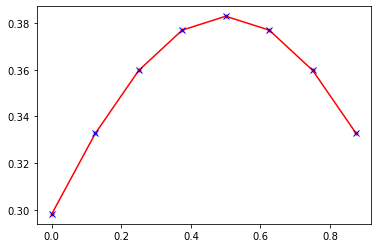

In [93]:
dmax = get_dmax(d,len(list_operator_to_implement))
state = qi.Statevector.from_instruction(qc)
state_dict = state.to_dict()
data = []
n_bits = len(list(state_dict.keys())[0])
for i in list(state_dict.keys()):
    if i[n_bits-1] == '0':
        data.append(state_dict[i])
L = np.array(data)
#L2 = np.angle(L)
X = np.array(range(2**n))/(2**n)
plt.plot(X,np.real(L)/np.linalg.norm(L),marker='.',c='r')
plt.plot(X,d(X)/np.linalg.norm(d(X)),marker='x',c='b',linestyle='')

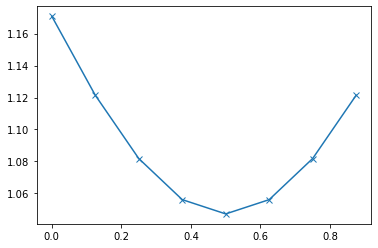

In [91]:
X = np.array(range(2**n))/(2**n)
plt.plot(X,f(X,d,dmax),marker='x')

## Sequential

In [94]:
def sequential_coeff_non_unitary(j,f,N,d):
    """j-th coefficient of the N-th sequential decomposition of f
    Parameters
    ----------
    j : int
        Order of the sequential coefficient
    f : function
        Function of one variable
    N : int
        Integer representing the number of points on which is computed the sequential coefficient
    d : function
        Function of one variable
    Returns
    -------
    float
    """
    dmax = get_dmax(d,N)
    return f(j/N,d,dmax)

In [98]:
def sequential_informations_non_unitary(n,list_operator_to_implement,f,d,gray_code=True):
    """Returns a dictionnary whose keys are the order of sequential operators to implement and the
    values are the associated coefficients
    Parameters
    ----------
    n : int
        Number of qubit encoding the position
    list_operator_to_implement : int list
        List of orders of the Walsh operators to implement
    f : function
        Function of one variable
    d : function
        Function of one variable
    gray_code : bool
        Set to True if to get a gray code ordering of the orders of the Walsh operators
    Returns
    -------
    dict
    """
    sequential_dict = {}
    n_operator_to_implement = len(list_operator_to_implement)
    if gray_code:
        gray_list = generate_gray_code(n)
        for i in gray_list:
            if i in list_operator_to_implement:
                sequential_dict[i] = sequential_coeff_non_unitary(i,f,n_operator_to_implement,d)
    else:
        for i in range(n_operator_to_implement): 
            sequential_dict[list_operator_to_implement[i]] = sequential_coeff_non_unitary(list_operator_to_implement[i],f,n_operator_to_implement,d)
    return sequential_dict

In [101]:
def sequential_circuit_non_unitary(n,n_ancilla_qsp,f,sequential_info,gray_code=True):
    """Generates the quantum circuit implementing the Sequential decomposition of function f with the Sequential operators
        whose orders are contain in sequential_info
    Parameters
    ----------
    n : int
        Number of qubit encoding the position
    n_ancilla_qsp : int
        Number of ancilla qubits used to control the rotations gates
    f : function
        Function of one variable
    sequential_info : dict
        Output of function sequential_informations_non_unitary, it is a dictionnary whose keys are the order of Sequential operator
        to implement and the values are the associated coefficients
    gray_code : bool
        Set to True if to get a gray code ordering of the orders of the Sequential operators
    Returns
    -------
    qiskit.circuit.quantumcircuit.QuantumCircuit
    """
    q = QuantumRegister(n,name='q')
    a_qsp = AncillaRegister(n_ancilla_qsp+1,name='a_qsp')
    qc = QuantumCircuit(q,a_qsp)
    
    q_qubits = qc.qubits[:n]
    a_qsp_qubits = qc.qubits[n:]
    
    sequential_operators_list = []
    sequential_operators_dagger_list = []
    order_list = list(sequential_info.keys())
    for order in order_list:
        if gray_code:
            sequential_operators_dagger_list.append(sequential_operator(n,order,-sequential_info[order],nots=False))
            sequential_operators_list.append(sequential_operator(n,order,sequential_info[order],nots=False))
        else:
            sequential_operators_dagger_list.append(sequential_operator(n,order,-sequential_info[order]))
            sequential_operators_list.append(sequential_operator(n,order,sequential_info[order]))
    qsp_control_index = 0
    for index,operator in enumerate(sequential_operators_list):
        if gray_code:
            # avoid putting the useless cnots
            if index == 0:
                nots_index = bits_to_zero(int_to_binary(order_list[index],n,reverse=True))
                for j in nots_index:
                    qc.x(q[j])
                qc.append(sequential_operators_dagger_list[index].control(1),[a_qsp_qubits[qsp_control_index]]+q_qubits)
                qc.append(operator.control(1,ctrl_state='0'),[a_qsp_qubits[qsp_control_index]]+q_qubits)
            elif index > 0:
                current_index = int_to_binary(order_list[index],n,reverse=True)
                previous_index = int_to_binary(order_list[index-1],n,reverse=True)
                nots_index = changing_index(current_index,previous_index)
                for j in nots_index:
                    qc.x(q[j])
                qc.append(sequential_operators_dagger_list[index].control(1),[a_qsp_qubits[qsp_control_index]]+q_qubits)
                qc.append(operator.control(1,ctrl_state='0'),[a_qsp_qubits[qsp_control_index]]+q_qubits)
            if index == len(sequential_operators_list)-1:
                nots_index = bits_to_zero(int_to_binary(order_list[index],n,reverse=True))
                for j in nots_index:
                    qc.x(q[j])
        else:
            qc.append(sequential_operators_dagger_list[index].control(1),[a_qsp_qubits[qsp_control_index]]+q_qubits)
            qc.append(operator.control(1,ctrl_state='0'),[a_qsp_qubits[qsp_control_index]]+q_qubits)
        qsp_control_index = (qsp_control_index+1)%(n_ancilla_qsp+1)
    return qc

In [105]:
def get_dmax(d,N):
    maxi = 0
    for i in range(N):
        if abs(d(i/N)) > maxi:
            maxi = abs(d(i/N))
    return maxi

def d(x):
    return np.exp(-(x-0.5)**2)
    #return np.sin(2*np.pi*x)

def f(x,d,dmax):
    return np.arccos(d(x)/(2*dmax))

n = 3
list_operator_to_implement = [i for i in range(2**n)]

gray_code = True

n_ancilla_adjustable = 3
n_ancilla_qsp = 3

q = QuantumRegister(n,name='q')
qA = QuantumRegister(1,name='qA')
a = AncillaRegister(n_ancilla_adjustable,name='a')
a_qsp = AncillaRegister(n_ancilla_qsp,name='a_qsp')
qc = QuantumCircuit(qA,q,a,a_qsp)

qA_qubits = qc.qubits[:1]
q_qubits = qc.qubits[1:n+1]
a_qubits = qc.qubits[n+1:n+1+n_ancilla_adjustable]
a_qsp_qubits = qc.qubits[n+1+n_ancilla_adjustable:n+1+n_ancilla_adjustable+n+1+n_ancilla_qsp]

old_qc_qubits = q_qubits+a_qubits
        
qc.h(qA)
qc.h(q)

# copy of qA
copy_gate_qsp = copy(qA,a_qsp)
qc.append(copy_gate_qsp,qA_qubits+a_qsp_qubits)

# copy of main register
if n_ancilla_adjustable >= n:
    copy_gate = copy(q,a)
    qc.append(copy_gate,q_qubits+a_qubits)

n_blocks = get_n_blocks(n,n_ancilla_adjustable)
n_rotations = len(list_operator_to_implement)
n_operator_per_block_list = n_operator_per_block(n_rotations,n_blocks)
sequential_info = sequential_informations_non_unitary(n,list_operator_to_implement,f,d,gray_code=gray_code)
for i in range(0,n_blocks):
    sequential_info_block = dict(list(sequential_info.items())[:n_operator_per_block_list[i]])
    qc.append(sequential_circuit_non_unitary(n,n_ancilla_qsp,f,sequential_info_block,gray_code=gray_code),old_qc_qubits[i*n:(i+1)*n]+qA_qubits+a_qsp_qubits)
    sequential_info = dict(list(sequential_info.items())[n_operator_per_block_list[i]:])
    #qc.barrier()

# undo copy of main register
if n_ancilla_adjustable >= n:
    qc.append(copy_gate.inverse(),q_qubits+a_qubits)

# undo copy of qA
qc.append(copy_gate_qsp.inverse(),qA_qubits+a_qsp_qubits)

qc.h(qA)
#qc.p(-np.pi/2,qA)

qc.draw()

┌───┐┌────────────────┐                  ┌────────────────┐»
     qA: ┤ H ├┤0               ├──────────────────┤3               ├»
         ├───┤│                │┌────────────────┐│                │»
    q_0: ┤ H ├┤                ├┤0               ├┤0               ├»
         ├───┤│                ││                ││                │»
    q_1: ┤ H ├┤                ├┤1               ├┤1               ├»
         ├───┤│                ││                ││                │»
    q_2: ┤ H ├┤                ├┤2               ├┤2               ├»
         └───┘│                ││  circuit-30273 ││                │»
    a_0: ─────┤                ├┤3               ├┤                ├»
              │  circuit-30270 ││                ││  circuit-30276 │»
    a_1: ─────┤                ├┤4               ├┤                ├»
              │                ││                ││                │»
    a_2: ─────┤                ├┤5               ├┤                ├»
              │                │└────────────────┘│                │»
a_qsp_0: ─────┤1               ├──────────────────┤4               ├»
              │                │                  │                │»
a_qsp_1: ─────┤2               ├──────────────────┤5               ├»
              │                │                  │                │»
a_qsp_2: ─────┤3               ├──────────────────┤6               ├»
              └────────────────┘                  └────────────────┘»
«         ┌────────────────┐                     ┌───────────────────┐┌───┐
«     qA: ┤3               ├─────────────────────┤0                  ├┤ H ├
«         │                │┌───────────────────┐│                   │└───┘
«    q_0: ┤                ├┤0                  ├┤                   ├─────
«         │                ││                   ││                   │     
«    q_1: ┤                ├┤1                  ├┤                   ├─────
«         │                ││                   ││                   │     
«    q_2: ┤                ├┤2                  ├┤                   ├─────
«         │                ││  circuit-30273_dg ││                   │     
«    a_0: ┤0               ├┤3                  ├┤                   ├─────
«         │  circuit-30463 ││                   ││  circuit-30270_dg │     
«    a_1: ┤1               ├┤4                  ├┤                   ├─────
«         │                ││                   ││                   │     
«    a_2: ┤2               ├┤5                  ├┤                   ├─────
«         │                │└───────────────────┘│                   │     
«a_qsp_0: ┤4               ├─────────────────────┤1                  ├─────
«         │                │                     │                   │     
«a_qsp_1: ┤5               ├─────────────────────┤2                  ├─────
«         │                │                     │                   │     
«a_qsp_2: ┤6               ├─────────────────────┤3                  ├─────
«         └────────────────┘                     └───────────────────┘

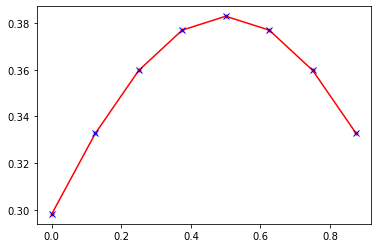

In [106]:
dmax = get_dmax(d,len(list_operator_to_implement))
state = qi.Statevector.from_instruction(qc)
state_dict = state.to_dict()
data = []
n_bits = len(list(state_dict.keys())[0])
for i in list(state_dict.keys()):
    if i[n_bits-1] == '0':
        data.append(state_dict[i])
L = np.array(data)
#L2 = np.angle(L)
X = np.array(range(2**n))/(2**n)
plt.plot(X,np.real(L)/np.linalg.norm(L),marker='.',c='r')
plt.plot(X,d(X)/np.linalg.norm(d(X)),marker='x',c='b',linestyle='')